In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_parquet('/Users/guenounraphael/Desktop/Cyclist project/Code/data_train_merged.parquet')
df_train = df_train.set_index('index')
df_test = pd.read_parquet('/Users/guenounraphael/Desktop/Cyclist project/Code/data_test_merged.parquet')
df_test = df_test.set_index('index')

Based on our previus explonatory data anylis, wez remove the predictors that are too correlated or that are redundant. A

In [3]:
df_train = df_train.drop(columns=["counter_id", "site_id", "bike_count", "counter_installation_date", "counter_technical_id", "latitude", "longitude","coordinates"], axis=1)


df_train

,counter_name,site_name,date,log_bike_count,numer_sta,pmer,tend,cod_tend,dd,ff,...,rr1,rr3,rr6,rr12,rr24,quarantine1,quarantine2,christmas,holiday,bank_holiday
index,,,,,,,,,,,,,,,,,,,,,
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,7149,102050,-10,8,340,1.6,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,False
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,7149,101990,-60,6,290,1.1,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,False
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,7149,101990,-60,6,290,1.1,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,False
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,7149,101740,-110,6,40,4.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,False
5,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,7149,101760,10,3,20,3.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 06:00:00,6.100319,7149,101130,-10,5,240,2.3,...,0.0,0.0,-0.1,1.2,1.2,0,0,0,False,False
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 10:00:00,4.983607,7149,101200,80,1,210,3.5,...,0.0,0.0,0.0,1.2,1.2,0,0,0,False,False
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 15:00:00,5.389072,7149,101070,-70,6,230,5.5,...,0.0,0.0,0.0,0.0,1.2,0,0,0,False,False


In [6]:
df_test = df_test.drop(columns=["counter_id", "site_id", "counter_installation_date", "counter_technical_id", "latitude", "longitude","coordinates"], axis=1)


df_test

KeyError: "['counter_id', 'site_id', 'counter_installation_date', 'counter_technical_id', 'latitude', 'longitude', 'coordinates'] not found in axis"

In [ ]:
df_train['quarantine1'] = df_train['quarantine1'].astype(bool)
df_train['quarantine2'] = df_train['quarantine2'].astype(bool)
df_train['christmas'] = df_train['christmas'].astype(bool)

df_test['quarantine1'] = df_test['quarantine1'].astype(bool)
df_test['quarantine2'] = df_test['quarantine2'].astype(bool)
df_test['christmas'] = df_test['christmas'].astype(bool)

In [ ]:
train_numerical_columns = df_train.select_dtypes(include=['float', 'int']).drop(columns = ["log_bike_count"])
train_categorical_columns = df_train.select_dtypes(include=['object', 'category'])
train_bool_columns = df_train.select_dtypes(include=['bool'])

In [ ]:
train_numerical_columns.columns

In [7]:
def encoder_for_dates(X):
    X = X.copy() 
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X["weekend"] = X["weekday"] > 4
    return X.drop(columns=["date"])

encoder_for_dates(df_train)
   

,counter_name,site_name,log_bike_count,numer_sta,pmer,tend,cod_tend,dd,ff,t,...,quarantine2,christmas,holiday,bank_holiday,year,month,day,weekday,hour,weekend
index,,,,,,,,,,,,,,,,,,,,,
1,28 boulevard Diderot E-O,28 boulevard Diderot,0.000000,7149,102050,-10,8,340,1.6,285.75,...,False,False,False,False,2020,9,1,1,2,False
2,28 boulevard Diderot E-O,28 boulevard Diderot,0.693147,7149,101990,-60,6,290,1.1,283.95,...,False,False,False,False,2020,9,1,1,3,False
3,28 boulevard Diderot E-O,28 boulevard Diderot,0.000000,7149,101990,-60,6,290,1.1,283.95,...,False,False,False,False,2020,9,1,1,4,False
4,28 boulevard Diderot E-O,28 boulevard Diderot,1.609438,7149,101740,-110,6,40,4.0,293.65,...,False,False,False,False,2020,9,1,1,15,False
5,28 boulevard Diderot E-O,28 boulevard Diderot,2.302585,7149,101760,10,3,20,3.0,292.15,...,False,False,False,False,2020,9,1,1,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,6.100319,7149,101130,-10,5,240,2.3,292.85,...,False,False,False,False,2021,9,9,3,6,False
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,4.983607,7149,101200,80,1,210,3.5,293.45,...,False,False,False,False,2021,9,9,3,10,False
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,5.389072,7149,101070,-70,6,230,5.5,299.35,...,False,False,False,False,2021,9,9,3,15,False


In [8]:
encoder_for_dates(df_train).nunique()

counter_name        56
site_name           30
log_bike_count     998
numer_sta            1
pmer               461
tend                97
cod_tend             9
dd                  37
ff                 106
t                  345
td                 277
u                   77
vv                1137
ww                  42
w1                   9
w2                   9
n                   10
nbas                10
pres               458
tend24             340
raf10              168
rafper             182
per                  1
etat_sol             9
ht_neige             7
rr1                 31
rr3                 58
rr6                 84
rr12               118
rr24               152
quarantine1          2
quarantine2          2
christmas            2
holiday              2
bank_holiday         2
year                 2
month               12
day                 31
weekday              7
hour                24
weekend              2
dtype: int64

In [9]:
def cyclical_encoding(X, column, max_val):
    X = X.copy()
    X[f"{column}_sin"] = np.sin(2 * np.pi * X[column] / max_val)
    X[f"{column}_cos"] = np.cos(2 * np.pi * X[column] / max_val)
    return X

In [10]:
def fit_encoder(X_train):
    global year_encoder, month_encoder, weekday_encoder, category_encoder, numerical_encoder
    
    X_train = encoder_for_dates(X_train)
    
    year_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[["year"]])
    month_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[["month"]])
    category_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[['counter_name', 'site_name']])
    weekday_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[["weekday"]])
    
    numerical_encoder = StandardScaler().fit(X_train[["cod_tend", "t", "u", "raf10", "etat_sol"]])

Since year, months, weekdays, and category have a quite low cardinality, it seems reasonable to use on hot encoding here. Moreover, based on the cyclical pattern of hour and day of these predictors, we also proceeded with cyclical encoding for them

In [11]:
def encoder(X):
    X_encoded = encoder_for_dates(X)

    X_encoded = cyclical_encoding(X_encoded, "hour", 24)
    X_encoded = cyclical_encoding(X_encoded, "day", 31)
    
    years_encoded = year_encoder.transform(X_encoded[["year"]])
    months_encoded = month_encoder.transform(X_encoded[["month"]])
    weekdays_encoded = weekday_encoder.transform(X_encoded[["weekday"]])
    categories_encoded = category_encoder.transform(X_encoded[["counter_name", "site_name"]])
    numerical_encoded = numerical_encoder.transform(X_encoded[["cod_tend", "t", "u", "raf10", "etat_sol"]])

    years_df = pd.DataFrame(years_encoded, columns=["2020", "2021"])
    months_df = pd.DataFrame(months_encoded, columns=["janv", "fev", "mars", "avril", "mai", "juin", "juillet", "aout", "sept", "octobre", "novem", "decembre"])
    weekdays_df = pd.DataFrame(weekdays_encoded, columns=[f"weekday_{i}" for i in range(weekdays_encoded.shape[1])])
    categories_df = pd.DataFrame(categories_encoded, columns=[f"cat_{i}" for i in range(categories_encoded.shape[1])])
    numerical_df = pd.DataFrame(numerical_encoded, columns=["cod_tend", "t", "u", "raf10", "etat_sol"])

    
    X_encoded.reset_index(drop=True, inplace=True)
    X_encoded = pd.concat([X_encoded, years_df, months_df, weekdays_df, categories_df, numerical_df], axis=1)

    X_encoded.drop(columns=["year", "month", "weekday", "day", "hour", "counter_name", "site_name", "cod_tend", "t", "u", "raf10", "etat_sol"], inplace=True)
    
    return X_encoded

In [12]:

X_train = df_train.drop(columns=["log_bike_count"])
y_train = df_train["log_bike_count"]

X_test = df_test


In [13]:
fit_encoder(X_train)
X_train_encoded = encoder(X_train)
X_test_encoded = encoder(X_test)

X_test_encoded

,numer_sta,pmer,tend,dd,ff,td,vv,ww,w1,w2,...,cat_76,cat_77,cat_78,cat_79,cat_80,cat_81,cat_82,cat_83,cat_84,cat_85
0,7149,101240,0,200,2.0,290.45,34270,0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7149,101410,-30,220,1.8,292.15,10000,25,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7149,101400,-10,220,5.1,290.35,20000,1,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7149,101540,130,240,2.7,290.25,5000,81,9.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7149,101740,190,310,1.8,288.85,48230,1,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,7149,102250,70,170,2.4,282.05,12000,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51436,7149,102100,-40,200,5.2,286.65,35350,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51437,7149,102100,-40,200,5.2,286.65,35350,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51438,7149,102150,40,220,1.9,287.15,20000,61,6.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:

import xgboost as xgb

In [15]:

models = {
    "RandomForest": RandomForestRegressor(n_estimators=  2 , random_state=42),
    "Ridge": Ridge(),
    "XGBoost": xgb.XGBRegressor(verbosity=0, random_state=42),
    }

In [16]:

def train_and_predict_submission(X_train, y_train, X_test, model, model_name):
    transformer = FunctionTransformer(encoder)
    pipeline = make_pipeline(transformer, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    submission_df = pd.DataFrame({
        "Id": range(len(y_pred)), 
        "log_bike_count": y_pred 
    })
    submission_df.to_csv(f"submission_{model_name}.csv", index=False)
    print(f"{model_name}: Submission file saved as submission_{model_name}.csv")

for model_name, model in models.items():
    print(f"Training and predicting with {model_name}...")
    train_and_predict_submission(X_train, y_train, X_train, model, model_name)




Training and predicting with RandomForest...
RandomForest: Submission file saved as submission_RandomForest.csv
Training and predicting with Ridge...
Ridge: Submission file saved as submission_Ridge.csv
Training and predicting with XGBoost...
XGBoost: Submission file saved as submission_XGBoost.csv


Based on our submission on the Kaggle (before tunning), the best model (The one with the smallest RMSE is XGtboost with a RMSE = 0.6921)

We are now going to proceed with a grid search to find and tune the best hyperparameters.

## GRID SEARCH

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb


# Réduire la taille de l'échantillon (50% des données)
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_encoded, y_train, test_size=0.5, random_state=42
)

param_grid = {
    'max_depth': [6],
    'learning_rate': [0.2,0.3],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(verbosity=0, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_sampled, y_train_sampled)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score (RMSE) :", -grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Meilleur score (RMSE) : 0.40167801878604087


In [17]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb

# Use the best parameters found from GridSearchCV
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8
}
best_xgb_model = xgb.XGBRegressor(**best_params, verbosity=0, random_state=42)

transformer = FunctionTransformer(encoder)
pipeline = make_pipeline(transformer, best_xgb_model)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

submission_df = pd.DataFrame({
    "Id": range(len(y_pred)), 
    "log_bike_count": y_pred 
})
submission_df.to_csv("final_submission.csv", index=False)

print("XGBoost: Submission file saved as final_submission.csv")


XGBoost: Submission file saved as final_submission.csv


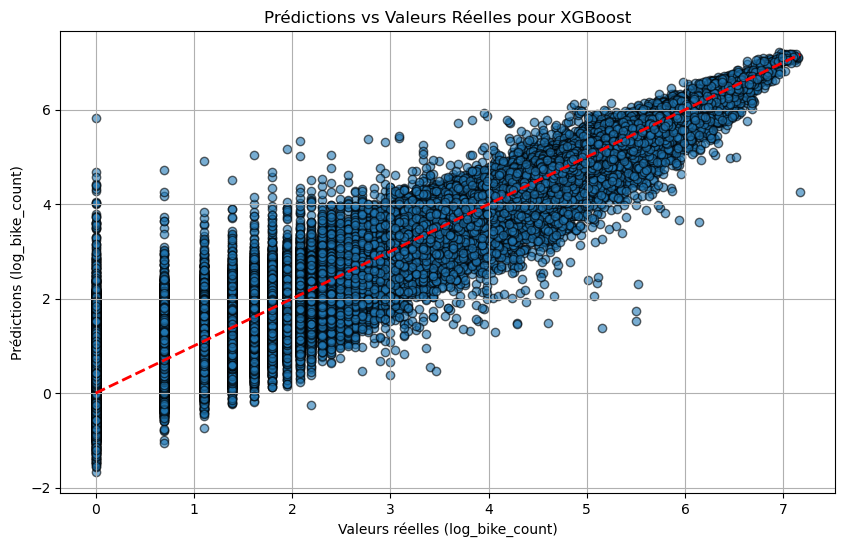

In [18]:
import matplotlib.pyplot as plt

def plot_best_model_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Valeurs réelles (log_bike_count)")
    plt.ylabel("Prédictions (log_bike_count)")
    plt.title(f"Prédictions vs Valeurs Réelles pour {model_name}")
    plt.grid(True)
    plt.show()

y_train_pred = pipeline.predict(X_train)  

plot_best_model_predictions(y_train, y_train_pred, "XGBoost")


